In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [63]:
df=pd.read_csv('processed.csv')
print('Data shape:',df.shape)

Data shape: (1069, 22)


In [64]:
list(enumerate(df.columns))

[(0, 'w/b'),
 (1, 'Water'),
 (2, 'Cement type'),
 (3, 'Cement'),
 (4, 'Slag'),
 (5, 'Fly ash'),
 (6, 'Silica fume'),
 (7, 'Lime filler'),
 (8, 'FA'),
 (9, 'CA'),
 (10, 'Plasticizer'),
 (11, 'Superplasticizer'),
 (12, 'Air entraining'),
 (13, 'Comp. str. test age'),
 (14, 'Compressive strength'),
 (15, 'Air content'),
 (16, 'Spreed'),
 (17, 'Slump'),
 (18, 'Fresh density'),
 (19, 'Dry  density'),
 (20, 'Migration test age'),
 (21, 'Migration resistance')]

1-hot encoding

In [65]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')
X=ct.fit_transform(df)
# remove dummy variable and output
y=X[:,-1]
X=X[:,1:-1]
print(X.shape)
print(y.shape)

(1069, 30)
(1069,)


Decision Tree

Split 0:
{'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.8035087719298245
Split 1:
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.7964912280701754
Split 2:
{'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.8269005847953217
Split 3:
{'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.7883040935672515
Split 4:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.7921324629402966
Test acc: 0.8550612083717256
Train acc: 1.0


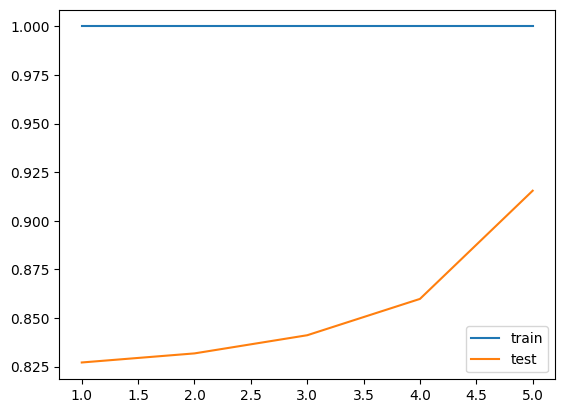

In [66]:
acc_train=[]
acc_test=[]
param_grid={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [10,50,100,200],
    'max_features': [None,1,2,3,4,5],
    'max_depth': [None,2,4,5,6],
    'min_samples_leaf': [1,3,4,5],
    'min_samples_split': [2,4,6,8,10]
}
splits=list(KFold(shuffle=True,random_state=0).split(X,y))
i=0
for train_index, test_index in splits:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    clf = RandomForestClassifier(random_state=0)
    grid=GridSearchCV(clf,param_grid,cv=5,n_jobs=-1,scoring='accuracy')
    grid.fit(X_train, y_train)
    print(f"Split {i}:")
    print(grid.best_params_)
    print(grid.best_score_)
    acc_train.append(accuracy_score(y_train,grid.predict(X_train)))
    acc_test.append(accuracy_score(y_test,grid.predict(X_test)))
    i+=1
print('Test acc:',np.mean(acc_test))
print('Train acc:',np.mean(acc_train))
plt.plot(range(1,6),acc_train)
plt.plot(range(1,6),acc_test)
plt.legend(['train','test'])